# Stress Testing: Predicting Loss under Adverse Economic Conditions.

## This script demonstrates a basic work flow for stress testing in banking portfolio.

### Loading Python libraries.

In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Reading data files and combine LoanHistory and FedHistory.

In [6]:
# Read credit portfolio.
myPortfolio = pd.read_excel("Loans.xlsx")

# Read historical loans.
myLoanHistory = pd.read_excel("OldLoans.xlsx")

# Read economic and financial data from the Fed.
FedHistory = pd.read_csv("FedHistory.csv")

# Combine both datasets
combinedHistory = pd.merge(myLoanHistory, FedHistory, on = "Year")

print(combinedHistory.head(10)) 

   ID  RiskLevel  CompanyAge  Year  Default  DJX_Return       GDP
0   1          1           1  2006        0   13.755301  2.409997
1   2          1           1  2006        1   13.755301  2.409997
2   3          1           1  2006        0   13.755301  2.409997
3   4          1           1  2006        1   13.755301  2.409997
4   5          1           1  2006        0   13.755301  2.409997
5   6          1           1  2006        0   13.755301  2.409997
6   7          1           1  2006        0   13.755301  2.409997
7   8          1           1  2006        0   13.755301  2.409997
8   9          1           1  2006        0   13.755301  2.409997
9  10          1           1  2006        0   13.755301  2.409997


### Build the default model

In [8]:
# Building of a Default model Model using borrower related variables (RiskLevel + CompanyAge) 
# and yearly economic input variables (DJX_Return + GDP)
model = smf.glm(formula = "Default ~ RiskLevel + CompanyAge + DJX_Return + GDP", 
                data = combinedHistory, 
                family = sm.families.Binomial())
# Model fitting.
result = model.fit()

# Display results.
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                Default   No. Observations:               227849
Model:                            GLM   Df Residuals:                   227844
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -18113.
Date:                Sat, 30 Nov 2024   Deviance:                       36226.
Time:                        21:43:12   Pearson chi2:                 2.21e+05
No. Iterations:                     8   Pseudo R-squ. (CS):           0.005259
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2208      0.054    -59.631      0.0

### Calculate default probabilities.

In [10]:
# Compute historical portfolio default rates per Company Age.
Default = []
for i in range(np.shape(combinedHistory["CompanyAge"].unique())[0]):
  CompanyAge = combinedHistory.loc[combinedHistory["CompanyAge"] == i + 1]
  DefaultFreq = CompanyAge["Default"].value_counts()
  DefaultRate = (DefaultFreq.values[1]/(DefaultFreq.values[0] + DefaultFreq.values[1]))*100
  Default.append(DefaultRate)

print(Default)

[2.1618015012510425, 2.5632599408478476, 2.7279947511999723, 1.9864765441614407, 1.3917285411958822, 0.8047281955389343, 0.600948484958187, 0.5411294715816234]


### In function StressTest default probabilities, default rates and expected loss are predicted for current loans under adverse economic conditions.

In [12]:
def StressTest(testnr):
    # Read stress test data
    AdverseScenario = pd.read_csv("StressCases.csv")

    # Portfolio under adverse economic conditions.
    AdversePortfolio = myPortfolio.assign(DJX_Return = AdverseScenario.iloc[testnr, 0], 
                                      GDP = AdverseScenario.iloc[testnr, 1])

    # Predicted default probabilities under adverse economic conditions for Loans based on our model.
    PD = result.predict(AdversePortfolio)

    # Dataframe containing company ages and predictive model probabilities under adverse economic conditions.
    predPD = pd.DataFrame({"CompanyAge": np.array(myPortfolio["CompanyAge"]), "PD": PD})

    # Compute predicted default rates.
    predDefault = []
    for i in range(np.shape(predPD["CompanyAge"].unique())[0]):
        CompanyAge = predPD.loc[predPD["CompanyAge"] == i + 1]
        predDefaultFreq = CompanyAge["PD"].mean()*100
        predDefault.append(predDefaultFreq)

    # Compute the expected loss of the loan portfolio under adverse economic conditions.
    ExpectedLoss = round(sum(AdversePortfolio["EAD"]*AdversePortfolio["LGD"]*PD),2)

    return predPD, predDefault, ExpectedLoss

### Visualization of historical and predicted portfolios under adverse economic conditions

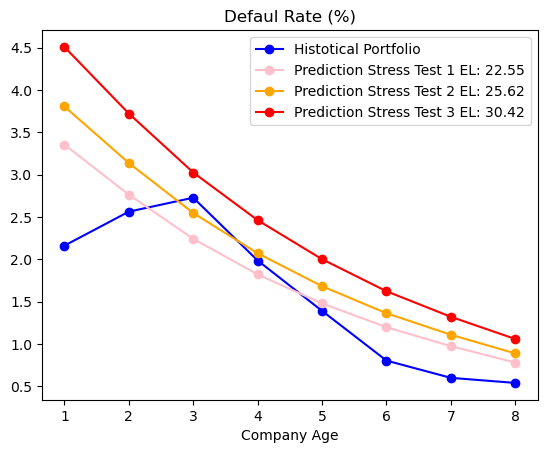

In [25]:
# Visualization with matplotlib.
plt.plot(combinedHistory["CompanyAge"].unique(), Default, "o-", color = "blue", label = "Histotical Portfolio")
plt.title("Defaul Rate (%)")
plt.xlabel("Company Age")
plt.legend()

colorlist = ["pink", "orange", "red"]

for i in range(3):
    predPD, predDefault, ExpectedLoss = StressTest(i)
 
    plt.plot(predPD["CompanyAge"].unique(), predDefault, "o-", color = colorlist[i], label = "Prediction Stress Test " 
             + str(i + 1) + " EL: " + str(ExpectedLoss))
    plt.title("Defaul Rate (%)")
    plt.xlabel("Company Age")
    plt.legend()

plt.show()